## Example 6: Henon-Heiles Hamiltonian (Anharmonic oscillator) by HO-DVR

This sample corresponds to [test sample](../../tests/test_henon_heiles.py)

In dimensionless form, the Henon-Heiles Hamiltonian is given by

$$
\hat{H} = \frac{\omega}{2}\sum_{i=1}^{f} \left( - \frac{\partial^2}{\partial Q_i^2} + Q_i^2 \right) + \lambda \left( \sum_{i=1}^{f-1} Q_i^2 Q_{i+1} - \frac{1}{3} Q_{i+1}^3 \right)
$$

But PyTDSCF adopts mass-weighted coordinate, thus the Hamiltonian is given by

$$
\hat{H} = \frac{1}{2}\sum_{i=1}^{f} \left( - \frac{\partial^2}{\partial q_i^2} + \omega^2 q_i^2 \right) + \lambda \omega^{\frac{3}{2}} \left( \sum_{i=1}^{f-1} q_i^2 q_{i+1} - \frac{1}{3} q_{i+1}^3 \right)
$$

where $Q_i = \sqrt{\omega} q_i$.



| run type      | wavefunction | backend | Basis  | steps |
| ---           | ---          | ---     | ---    | ---   |
| propagation | MPS-SM | Numpy   | HO-DVR | 100    |

### 1. Define parameters
```
    ω (float): frequency in cm-1
    λ (float): coupling strength in a.u.
    f (int): degree of freedom
    N (int): number of grid points for each degree of freedom
    m (int): MPS bond dimension
    Δt (float): time step size in femtosecond. If spectrum norm of Hamiltonian is large, Δt should be smaller.
    backend (str) : JAX or Numpy. (JAX takes 4 seconds, Numpy takes 1 seconds in M2 Macbook Air)
```

In [1]:
ω = 3000
λ = 1.0e-07
f = 3
N = 10
m = 10
Δt = 0.1
backend = "numpy"

### 2. Import modules

In [2]:
from typing import Callable

from discvar import HarmonicOscillator as HO

from pytdscf import BasInfo, Model, Simulator, units, __version__
from pytdscf.dvr_operator_cls import (
    TensorOperator,
    construct_kinetic_operator,
    construct_nMR_recursive,
)
from pytdscf.hamiltonian_cls import TensorHamiltonian
__version__

'1.2.0'

### 3. Define HO-DVR grid basis set

DVR function documentation is [here](https://qclovers.github.io/PyTDSCF/pytdscf.dvr_primitives.html#pytdscf.dvr_primitives.ho.HarmonicOscillator)

In [3]:
dvr_prims = [HO(N, ω) for _ in range(f)]
basinfo = BasInfo([dvr_prims])

**Plot HO-DVR**

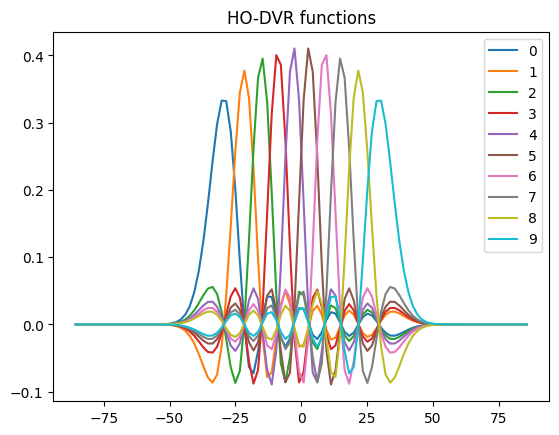

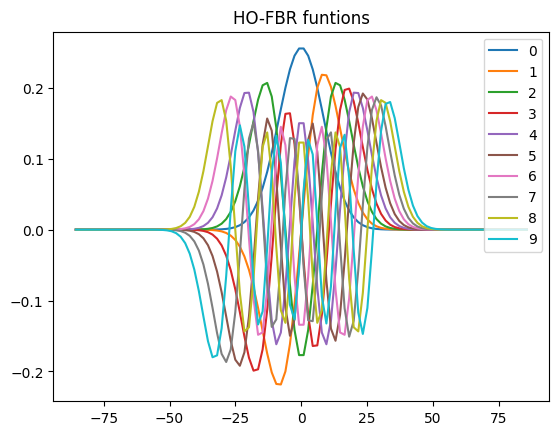

In [4]:
dvr_prims[0].plot_dvr()
dvr_prims[0].plot_fbr()

### 4. Define Anharmonic potential

- If you use different frequencyies, be careful to "late binding" of Python.

In [5]:
ω_au = ω / units.au_in_cm1

# Potential Function of each degree of freedom pair
henon_heiles_func: dict[tuple[int, ...], Callable] = {}
for idof in range(f):
    if idof == 0:
        henon_heiles_func[(0,)] = lambda Q1: pow(ω_au, 2) / 2 * Q1**2
        if f > 1:
            henon_heiles_func[(0, 1)] = (
                lambda Q1, Q2: λ * pow(ω_au, 3 / 2) * (Q1**2 * Q2)
            )
    elif idof == f - 1:
        henon_heiles_func[(f - 1,)] = (
            lambda Qf: pow(ω_au, 2) / 2 * Qf**2
            - λ * pow(ω_au, 3 / 2) / 3 * Qf**3
        )
    else:
        henon_heiles_func[(idof,)] = (
            lambda Qi: pow(ω_au, 2) / 2 * Qi**2
            - λ * pow(ω_au, 3 / 2) / 3 * Qi**3
        )
        henon_heiles_func[(idof, idof + 1)] = (
            lambda Qi, Qi1: λ * pow(ω_au, 3 / 2) * (Qi**2 * Qi1)
        )

In [6]:
henon_heiles_func

{(0,): <function __main__.<lambda>(Q1)>,
 (0, 1): <function __main__.<lambda>(Q1, Q2)>,
 (1,): <function __main__.<lambda>(Qi)>,
 (1, 2): <function __main__.<lambda>(Qi, Qi1)>,
 (2,): <function __main__.<lambda>(Qf)>}

### 5. Construct MPO

Refer to [this document](https://qclovers.github.io/PyTDSCF/pytdscf.html#pytdscf.dvr_operator_cls.construct_nMR_recursive) for more details of `construct_nMR_recursive` function.

In [7]:
mpo = construct_nMR_recursive(
    dvr_prims, nMR=2, func=henon_heiles_func, rate=0.99999999999
)

13:59:02 | INFO | scalar term 0.0 is excluded from MPO.
13:59:02 | INFO | DONE: construct 2 quasi full-dimensional MPOs
13:59:02 | INFO | 0-2: part of full-dimensional MPOs optimization
13:59:02 | INFO | Execute (10, 110) matrix SVD in 0-1 sites MPO optimization
13:59:02 | INFO | Execute (20, 10) matrix SVD in 1-2 sites MPO optimization
13:59:02 | INFO | 0-1: full-dimensional MPOs optimization
13:59:02 | INFO | Execute (10, 30) matrix SVD in 0-1 sites MPO optimization
13:59:02 | INFO | Execute (20, 10) matrix SVD in 1-2 sites MPO optimization
13:59:02 | INFO | 0-sweep: full-dimensional MPOs optimization
13:59:02 | INFO | 1-sweep: full-dimensional MPOs optimization
13:59:02 | INFO | 2-sweep: full-dimensional MPOs optimization
13:59:02 | INFO | 3-sweep: full-dimensional MPOs optimization
13:59:02 | INFO | final MPO bond-dimension [2, 3]


In [8]:
for core in mpo:
    print(core.shape)

(1, 10, 2)
(2, 10, 3)
(3, 10, 1)


### 6. Define Hamiltonian

In [9]:
# MPO has legs on (0,1,2, ... ,f-1) sites. This legs are given by tuple key
V = {tuple([idof for idof in range(f)]): TensorOperator(mpo=mpo)}
# V₀₀ is given by
potential = [[V]]

# Kinetic energy operator is given by
K = construct_kinetic_operator(dvr_prims)
# K₀₀ is given by
kinetic = [[K]]

H = TensorHamiltonian(
    ndof=f, potential=potential, kinetic=kinetic, backend=backend
)
operators = {"hamiltonian": H}

### 7. Define model of Wavefunction and Operators

In [10]:
model = Model(basinfo=basinfo, operators=operators)
model.m_aux_max = m
vib_gs = [1.0] + [0.0] * (N - 1)
vib_es = [0.0] + [1.0] + [0.0] * (N - 2)
print([[vib_es] + [vib_gs] * (f - 1)])
model.init_weight_VIBSTATE = [
    [vib_es] + [vib_gs] * (f - 1)
]  # only first mode is excited

[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]


### 8. Execute simulation

In [11]:
jobname = "henon_heiles"
simulator = Simulator(jobname=jobname, model=model, backend=backend)
simulator.propagate(maxstep=100, stepsize=Δt)

13:59:02 | INFO | Log file is ./henon_heiles_prop/main.log
13:59:02 | INFO | Wave function is saved in wf_henon_heiles.pkl
13:59:02 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

13:59:02 | INFO | End     0 step; propagated    0.100 [fs]; AVG Krylov iteration: 4.00
13:59:03 | INFO | End    99 step; propagated    9.900 [fs]; AVG Krylov iteration: 4.00
13:59:03 | INFO | End simulation and save wavefunction
13:59:03 | INFO | Wave function is saved in wf_henon_heiles.pkl


(0.03417251439684915, <pytdscf.wavefunction.WFunc at 0x7f4a3a7a2030>)

### 9. Check result

In [12]:
!ls {jobname}*

henon_heiles_HO-DVR.ipynb  henon_heiles_Sine-DVR.ipynb

henon_heiles_prop:
autocorr.dat  expectations.dat	main.log  populations.dat


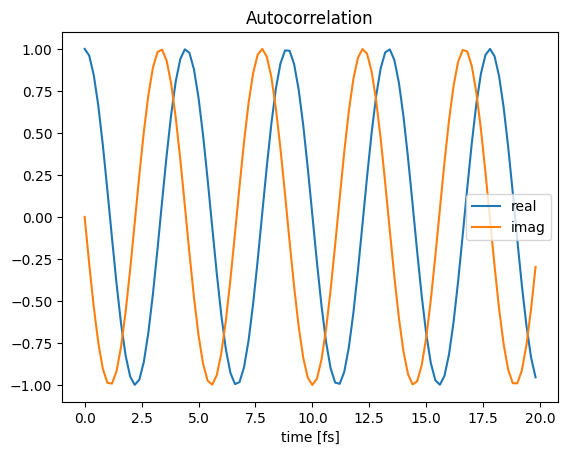

In [13]:
import matplotlib.pyplot as plt

from pytdscf import spectra

time, autocorr = spectra.load_autocorr(jobname + "_prop" + "/autocorr.dat")
plt.plot(time, autocorr.real, label="real")
plt.plot(time, autocorr.imag, label="imag")
plt.title("Autocorrelation")
plt.legend()
plt.xlabel("time [fs]")
plt.show()